In [85]:
import numpy as np
import pandas as pd
import os
import re
import string
import spacy
import tqdm
from collections import defaultdict, Counter
from pprint import pprint

from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import fetch_20newsgroups

import matplotlib.pyplot as plt
%matplotlib inline

In [82]:
categories = ['alt.atheism', 'talk.religion.misc',
               'comp.graphics', 'sci.space']

newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
pprint(list(newsgroups_train.target_names))
print("Number of examples:", len(newsgroups_train.data))

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
Number of examples: 2034


## Data exploration

In [58]:
df = pd.DataFrame({'text': newsgroups_train.data,
                   'target': newsgroups_train.target
                  })

print(newsgroups_train.data[0][:250])

df.head()

From: rych@festival.ed.ac.uk (R Hawkes)
Subject: 3DS: Where did all the texture rules go?
Lines: 21

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after rest


,target,text
0,1,From: rych@festival.ed.ac.uk (R Hawkes)\nSubje...
1,3,Subject: Re: Biblical Backing of Koresh's 3-02...
2,2,From: Mark.Perew@p201.f208.n103.z1.fidonet.org...
3,0,From: dpw@sei.cmu.edu (David Wood)\nSubject: R...
4,2,From: prb@access.digex.com (Pat)\nSubject: Con...


In [61]:
df['num_chars'] = df.text.apply(lambda x: len(x))
df['num_words'] = df.text.apply(lambda x: len(x.split()))
df['num_unique_words'] = df.text.apply(lambda x: len(Counter(x.split())))
df['avg_word_length'] = df.text.apply(lambda x: np.mean([len(w) for w in x.split()]))

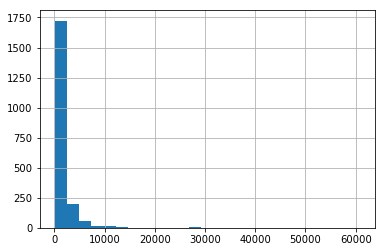

In [52]:
df.num_chars.hist(bins=25)

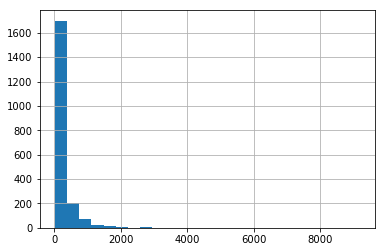

In [55]:
df.num_words.hist(bins=25)

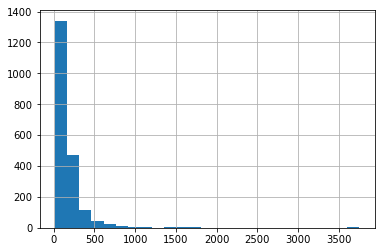

In [63]:
df.num_unique_words.hist(bins=25)

## Baseline model

In [83]:
params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

re_tok = re.compile('([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s):
    return re_tok.sub(r' \1 ', s).split()


lr_tfidf = Pipeline([
            ('feature_extraction', TfidfVectorizer(ngram_range=(1,4),  
                                                   lowercase=False,
                                                   tokenizer=tokenize,
                                                   stop_words='english',
                                                   min_df=3,
                                                   max_df=0.9,
                                                   strip_accents='unicode',
                                                   use_idf=True,
                                                   sublinear_tf=True
                                                  )),
            ('logistic_regression', GridSearchCV(
                            LogisticRegression(penalty='l2', 
                                               random_state=42), 
                                               param_grid=params))])

In [86]:
X = newsgroups_train.data
y = newsgroups_train.target

cross_val_score(lr_tfidf, X, y, cv=5, n_jobs=-1)

array([ 0.80637255,  0.80882353,  0.77886978,  0.7955665 ,  0.78024691])